In [69]:
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#impor mlp
from sklearn.neural_network import MLPClassifier
import pickle 

from openbb import obb
sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
from utils import local_data_interface as ldi
from assets.api_credentials import openbb_pat
obb.account.login(pat=openbb_pat, remember_me=True)

from utils import local_data_interface as ldi
import indicators as inds
from indicators import pandas_ta_indicators as pti
from indicators import tulipy_indicators as ti
from indicators import sets
from indicators import metaindicators as mi
from utils import ohlc_utils as ou

plt.rcParams['figure.figsize'] = [16, 4]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [ ]:
df = ldi.get_ticker(symbol='SPY', start_date="1980-01-01", end_date='2025-03-10', interval='1d')
extractor = inds.Extractor(sets.ema_ratios_vwap) #sets.z_score_close_volume) #sets.sma_ratios) #sets.all_custom_indicators) #sets.all_tulipy_defaults) #sets.all_candlestick_patterns)
# input_df = extractor.extract(df)
input_df = df.copy()
input_df.head()

,open,high,low,close,volume,vwap,adj_close,unadjusted_volume,change,change_percent
date,,,,,,,,,,
1993-01-29,43.97,43.97,43.75,43.94,1003200,43.9075,24.46,1003200.0,-0.03080,-0.000682
1993-02-01,43.97,44.25,43.97,44.25,480500,44.1100,24.63,480500.0,0.28125,0.006368
1993-02-02,44.22,44.38,44.13,44.34,201300,44.2675,24.68,201300.0,0.12500,0.002714
1993-02-03,44.41,44.84,44.38,44.81,529400,44.6100,24.94,529400.0,0.40625,0.009007
1993-02-04,44.97,45.09,44.88,45.00,531500,44.9850,25.05,531500.0,0.03125,0.000667


In [81]:
predict_ahead_days = 1
target_df = df['close'].shift(-predict_ahead_days) / df['close'] - 1 # calculate the percentage change in the closing price
target_df = target_df > 0 # make binary
target_df.head()

date
1993-01-29     True
1993-02-01     True
1993-02-02     True
1993-02-03     True
1993-02-04    False
Name: close, dtype: bool

In [82]:
# Drop rows with NaN values in either DataFrame
input_df = input_df.dropna()
target_df = target_df.dropna()

# Align the indices of input_df and target_df
input_df = input_df[input_df.index.isin(target_df.index)]
target_df = target_df[target_df.index.isin(input_df.index)]

len(input_df), len(target_df)

(8083, 8083)

In [83]:
train_test_split = .8
train_size = int(len(input_df) * train_test_split)
train_input_df = input_df.iloc[:train_size]
train_target_df = target_df.iloc[:train_size]
test_input_df = input_df.iloc[train_size:]
test_target_df = target_df.iloc[train_size:]

In [84]:
train_target_df.value_counts()

close
True     3442
False    3024
Name: count, dtype: int64

In [60]:
# from copy import deepcopy

class temporal_decision_tree():
    def __init__(self, max_depth = 10, embedded_learner = RidgeClassifier, embedding_dim = 3):
        self.max_depth = max_depth
        self.embedded_learner = embedded_learner
        self.embedding_dim = embedding_dim

    
    def fit(self, x, y):
        '''
        x: np array of shape (num_samples, num_features)
        y: np array of shape (num_samples,)
        '''
        x = segment_with_overlap(x.T, seg_n = self.embedding_dim, overlap_n = self.embedding_dim-1)
        y = y[self.embedding_dim-1:] #trim y to match lagged_feat by removing first embedding_dim-1 samples
        self.root = self.build_tree(x, y)
        
    def build_tree(self, x, y, depth = 0):
        '''
        x: np array of shape (num_samples, num_features)
        y: np array of shape (num_samples,)
        remaining_feats: np array of shape (num_remaining_feats,)
        '''
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return {'type': 'leaf', 'val': np.round(np.mean(y))}
        #find optimal split
        best_feat = None
        best_embedded_model = None
        best_score = 0
        best_predictions = None
        for feat_idx in range(x.shape[0]):
            feat = x[feat_idx]
            embedded_model = self.embedded_learner()
            embedded_model.fit(feat, y)
            predictions = embedded_model.predict(feat)
            score = np.sum(predictions == y) / len(y)
            if score > best_score:
                best_score = score
                best_embedded_model = embedded_model
                best_feat = feat_idx
                best_predictions = predictions
        #create node
        node = {'feat_idx': best_feat, 'model': best_embedded_model, 'type': 'branch'}
        #split data
        left_inds = best_predictions == 0
        right_inds = best_predictions == 1
        #build left and right subtrees
        if np.sum(left_inds) == 0 or np.sum(right_inds) == 0:
            return {'type': 'leaf', 'val': np.round(np.mean(y))}
        node['left'] = self.build_tree(x[:, left_inds, :], y[left_inds], depth+1)
        node['right'] = self.build_tree(x[:, right_inds, :], y[right_inds], depth+1)
        return node
    
    def predict(self, x):
        '''
        x: np array of shape (num_samples, num_features)
        '''
        x = segment_with_overlap(x.T, seg_n = self.embedding_dim, overlap_n = self.embedding_dim-1)
        preds = np.zeros(x.shape[1])
        for samp_idx in range(x.shape[1]):
            node = self.root
            while node['type'] != 'leaf':
                feat = x[node['feat_idx'], samp_idx].reshape(1,-1)
                if node['model'].predict(feat) == 0:
                    node = node['left']
                else:
                    node = node['right']
            preds[samp_idx] = node['val']
        return preds
        
    def segment(self, data, embedded_dim, stride):
        n_seg = (data.shape[0] - embedded_dim) // stride + 1  # number of segments
        shape = (n_seg, int(embedded_dim))  # output shape
        element_size = data.strides[-1]  # size of each data element in bytes
        strides = (stride * element_size, element_size)
        return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
    
def segment_with_overlap(data, seg_s=None, seg_n: int = None, overlap_s: float = None, overlap_n: int = None, fs: int = None):
    """
    Returns a view into data of shape [num_channels, num_seg, num_samples] with ability to overlap

    Input
    ------
    data: np.array
        Data of shape [num_channels, num_samples]. Must be 2d (for vectors, use np.reshape(1, -1))
    seg_s/seg_n: float
        Length of segments in seconds/samples
    overlap_s/overlap_n: float
        Amount of overlap in seconds/samples.
    fs: int
        Sampling frequency

    Returns
    -------
    segments : np.array
        Segmented data of shape [num_channels, num_seg, num_samples]
    """
    if  len(data.shape) != 2:
        raise ValueError("Data must be 2d. try adding a dimension with np.reshape(1, -1)")
    assert ((seg_s is not None) and (fs is not None)) or (
                seg_n is not None), "Must specify either seg_s and fs or seg_n"
    assert ((overlap_s is not None) and (fs is not None)) or (
                overlap_n is not None), "Must specify either overlap_s and fs or overlap_n"
    if seg_s is not None:
        seg_n = int(seg_s * fs)
    if overlap_s is not None:
        overlap_n = int(overlap_s * fs)
    stride = seg_n - overlap_n  # step size between segments
    n_seg = (data.shape[-1] - seg_n) // stride + 1  # number of segments
    shape = (data.shape[0], int(n_seg), seg_n)  # output shape
    element_size = data.strides[-1]  # size of each data element in bytes
    strides = (data.strides[0], stride * element_size, element_size)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [85]:
from datetime import datetime
tdt = temporal_decision_tree(max_depth=20, embedding_dim=5, embedded_learner = LogisticRegression)
now = datetime.now()

tdt.fit(train_input_df.values, train_target_df.values)
print("Elapsed time:", datetime.now() - now)
print()

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Elapsed time: 0:00:04.035607



In [86]:
preds = tdt.predict(train_input_df.values)
_y = train_target_df.values[-len(preds):]  # trim y to match preds
accuracy = np.sum(preds == _y)/len(_y)
print("Train set accuracy")
print("Temporal Decision Tree:", accuracy)
print()

Train set accuracy
Temporal Decision Tree: 0.5416279789538843



In [87]:
preds = tdt.predict(test_input_df.values[:, :-1])
_y = test_target_df.values[-len(preds):]  # trim y to match preds
accuracy = np.sum(preds == _y)/len(_y)
print("Test set accuracy")
print("Temporal Decision Tree:", accuracy)
print()

Test set accuracy
Temporal Decision Tree: 0.5412275263484191



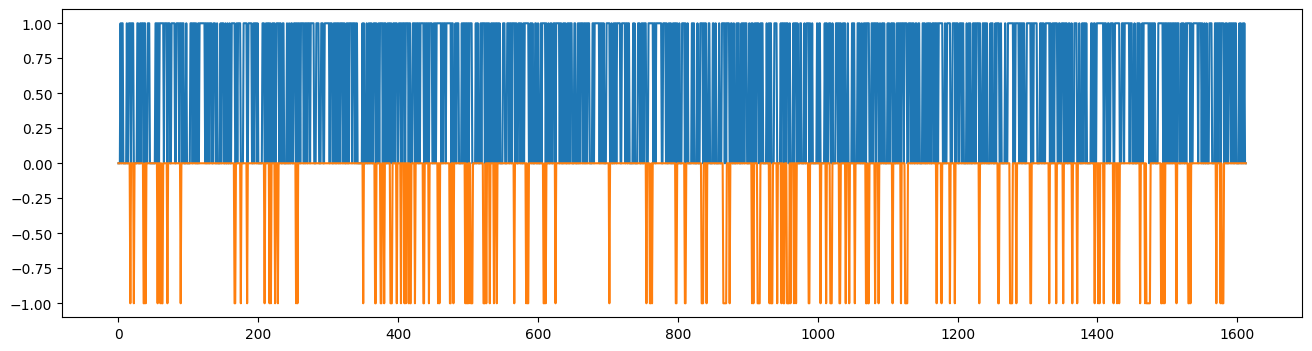

In [88]:
plt.plot(_y, label='True')
plt.plot(preds-1, label='Predictions')

In [89]:
def print_tree(node, depth = 0):
    if node['type'] == 'leaf':
        print('\t'*depth, node['val'])
    else:
        print('\t'*depth, node['feat_idx'])
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
        
print_tree(tdt.root)

 5
	 3
		 0
			 1
				 8
					 2
						 0.0
						 0
							 0.0
							 1.0
					 0
						 0.0
						 1.0
				 1.0
			 5
				 0.0
				 4
					 0.0
					 1.0
		 6
			 0
				 0.0
				 1.0
			 4
				 0
					 0.0
					 1.0
				 0
					 0.0
					 1.0
	 1.0


In [90]:
#compare with other methods
lag_dim = 3


#naive calssifier based on most common class in training set
preds = np.ones(test_target_df.shape[0]) * np.round(np.mean(train_target_df.values))
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("Naive:", accuracy)
print()

tdt = temporal_decision_tree(max_depth=25, embedding_dim=lag_dim)
now = datetime.now()
tdt.fit(train_input_df.values, train_target_df.values)
preds = tdt.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values[-len(preds):])/len(preds)
print("Temporal Decision Tree:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

dtc = DecisionTreeClassifier()
now = datetime.now()
dtc.fit(train_input_df.values, train_target_df.values)
preds = dtc.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("Decision Tree:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with DTC on lagged feature array
#create lagged values
x_train_lagged = segment_with_overlap(train_input_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_train_lagged = x_train_lagged.swapaxes(0,1)
x_train_lagged = x_train_lagged.reshape(x_train_lagged.shape[0], -1)
y_train_lagged = train_target_df.values[-len(x_train_lagged):]

x_test_lagged = segment_with_overlap(test_input_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_test_lagged = x_test_lagged.swapaxes(0,1)
x_test_lagged = x_test_lagged.reshape(x_test_lagged.shape[0], -1)
y_test_lagged = test_target_df.values[-len(x_test_lagged):]

dtc = DecisionTreeClassifier()
now = datetime.now()
dtc.fit(x_train_lagged, y_train_lagged)
preds = dtc.predict(x_test_lagged)
accuracy = np.sum(preds == y_test_lagged)/len(preds)
print("Lagged Decision Tree:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()


# compare with ridge classifier
rc = RidgeClassifier()
now = datetime.now()
rc.fit(train_input_df.values, train_target_df.values)
preds = rc.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("Ridge Classifier:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with ridge classifier on lagged feature array
rc = RidgeClassifier()
now = datetime.now()
rc.fit(x_train_lagged, y_train_lagged)
preds = rc.predict(x_test_lagged)
accuracy = np.sum(preds == y_test_lagged)/len(preds)
print("Lagged Ridge Classifier:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

# #compare with mlpc
# mlpc = MLPClassifier()
# now = datetime.now()
# mlpc.fit(train_input_df.values, train_target_df.values)
# preds = mlpc.predict(test_input_df.values)
# accuracy = np.sum(preds == test_target_df.values)/len(preds)
# print("MLP:", accuracy)
# print("Elapsed time:", datetime.now() - now)
# print()

# #compare with mlpc on lagged feature array
# mlpc = MLPClassifier()
# now = datetime.now()
# mlpc.fit(x_train_lagged, y_train_lagged)
# preds = mlpc.predict(x_test_lagged)
# accuracy = np.sum(preds == y_test_lagged)/len(preds)
# print("Lagged MLP:", accuracy)
# print("Elapsed time:", datetime.now() - now)
# print()



#compare with xgb
xgb_clf = xgb.XGBClassifier(n_estimators=1500)
now = datetime.now()
xgb_clf.fit(train_input_df.values, train_target_df.values)
preds = xgb_clf.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("XGB:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with xgb on lagged feature array
xgb_clf = xgb.XGBClassifier()
now = datetime.now()
xgb_clf.fit(x_train_lagged, y_train_lagged)
preds = xgb_clf.predict(x_test_lagged)
accuracy = np.sum(preds == y_test_lagged)/len(preds)
print("Lagged XGB:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with logistic regression
lr = LogisticRegression()
now = datetime.now()
lr.fit(train_input_df.values, train_target_df.values)
preds = lr.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("Logistic Regression:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with knn
knn = KNeighborsClassifier(n_neighbors=3)
now = datetime.now()
knn.fit(train_input_df.values, train_target_df.values)
preds = knn.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("KNN:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with random forest
rf = RandomForestClassifier()
now = datetime.now()
rf.fit(train_input_df.values, train_target_df.values)
preds = rf.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("Random Forest:",accuracy)
print("Elapsed time:", datetime.now() - now)
print()

#compare with svm
svm = SVC()
now = datetime.now()
svm.fit(train_input_df.values, train_target_df.values)
preds = svm.predict(test_input_df.values)
accuracy = np.sum(preds == test_target_df.values)/len(preds)
print("SVM:", accuracy)
print("Elapsed time:", datetime.now() - now)
print()

Naive: 0.5479282622139765

Temporal Decision Tree: 0.5467492260061919
Elapsed time: 0:00:03.177619

Decision Tree: 0.4842300556586271
Elapsed time: 0:00:00.122578

Lagged Decision Tree: 0.4972136222910217
Elapsed time: 0:00:00.335675

Ridge Classifier: 0.5497835497835498
Elapsed time: 0:00:00.012102

Lagged Ridge Classifier: 0.5393188854489164
Elapsed time: 0:00:00.011536



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.05624e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


XGB: 0.5009276437847866
Elapsed time: 0:00:01.416309

Lagged XGB: 0.5027863777089784
Elapsed time: 0:00:00.190940

Logistic Regression: 0.5479282622139765
Elapsed time: 0:00:00.045652

KNN: 0.5095856524427953
Elapsed time: 0:00:00.121834

Random Forest: 0.46691403834260975
Elapsed time: 0:00:02.502594

SVM: 0.5479282622139765
Elapsed time: 0:00:01.992229

